In [61]:
import preprocessor
import demoji
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from transformers import AutoTokenizer, AutoModelForSequenceClassification, BertweetTokenizer
import torch
from torch.utils.data import DataLoader, TensorDataset
from torch.nn import CrossEntropyLoss
from tqdm import tqdm

In [62]:
# Load BERTweet model and tokenizer
model_name = "vinai/bertweet-base"
# tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer = BertweetTokenizer.from_pretrained(model_name)

model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)

emoji is not installed, thus not converting emoticons or emojis into text. Install emoji: pip3 install emoji==0.6.0
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/bertweet-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [72]:
# Load your dataset with columns 'tweet' and 'categories'
dataset = pd.read_csv('./dataset/cleaned_dataset.csv')
dataset['label'] = dataset['label'].map({0: 1, 1: 0}) # swap label 0 to label 1 and vice versa
print(dataset.columns)
print(dataset.shape)
print(dataset.head(10))

Index(['label', 'tweet', 'label_category'], dtype='object')
(20620, 3)
   label                                              tweet  \
0      0  !!!!! rt @mleew17: boy dats cold...tyga dwn ba...   
1      0  !!!!!!! rt @urkindofbrand dawg!!!! rt @80sbaby...   
2      0  !!!!!!!!! rt @c_g_anderson: @viva_based she lo...   
3      0  !!!!!!!!!!!!! rt @shenikaroberts: the shit you...   
4      0  !!!!!!!!!!!!!!!!!!"@t_madison_x: the shit just...   
5      0  !!!!!!"@__brighterdays: i can not just sit up ...   
6      0  !!!!“@selfiequeenbri: cause i'm tired of you b...   
7      0  " & you might not get ya bitch back & thats th...   
8      0  " @rhythmixx_ :hobbies include: fighting maria...   
9      0  " keeks is a bitch she curves everyone " lol i...   

       label_category  
0  Offensive Language  
1  Offensive Language  
2  Offensive Language  
3  Offensive Language  
4  Offensive Language  
5  Offensive Language  
6  Offensive Language  
7  Offensive Language  
8  Offensive Langua

In [71]:
# # Load and preprocess your dataset
# def preprocess_text(text):
#     # Use tweet-preprocessor to clean tweets
#     cleaned_text = preprocessor.clean(text)
#     # Remove emojis
#     cleaned_text = remove_emojis(cleaned_text)
#     return cleaned_text

# def remove_emojis(text):
#     return demoji.replace(text, '')

# # Preprocess text
# dataset['label'] = dataset['label'].map({0: 1, 1: 0}) # swap label 0 to label 1 and vice versa
# # dataset['cleaned_tweet'] = dataset['tweet'].apply(preprocess_text)

# print(dataset.columns)
# print(dataset.shape)
# print(dataset.head(10))

Index(['label', 'tweet', 'label_category'], dtype='object')
(20620, 3)
   label                                              tweet  \
0      0  !!!!! rt @mleew17: boy dats cold...tyga dwn ba...   
1      0  !!!!!!! rt @urkindofbrand dawg!!!! rt @80sbaby...   
2      0  !!!!!!!!! rt @c_g_anderson: @viva_based she lo...   
3      0  !!!!!!!!!!!!! rt @shenikaroberts: the shit you...   
4      0  !!!!!!!!!!!!!!!!!!"@t_madison_x: the shit just...   
5      0  !!!!!!"@__brighterdays: i can not just sit up ...   
6      0  !!!!“@selfiequeenbri: cause i'm tired of you b...   
7      0  " & you might not get ya bitch back & thats th...   
8      0  " @rhythmixx_ :hobbies include: fighting maria...   
9      0  " keeks is a bitch she curves everyone " lol i...   

       label_category  
0  Offensive Language  
1  Offensive Language  
2  Offensive Language  
3  Offensive Language  
4  Offensive Language  
5  Offensive Language  
6  Offensive Language  
7  Offensive Language  
8  Offensive Langua

In [73]:
# Split the dataset into training and testing sets
X_train, X_test_temp, y_train, y_test_temp = train_test_split(
    dataset['tweet'],  # Features
    dataset['label'],  # Labels
    test_size=0.4, 
    random_state=42
)

# Split the testing set into validation (50%) and testing (50%)
X_val, X_test, y_val, y_test = train_test_split(
    X_test_temp,
    y_test_temp,
    test_size=0.5,
    random_state=42
)

# Reset the index to ensure it is consecutive
X_train.reset_index(drop=True, inplace=True)
X_val.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)

# Print the sizes of each set: Training 60% / Val 20% / Testing 20% 
print("Training set size:", len(X_train), "(Hate Speech: ", sum(y_train == 1), ", Non-Hate Speech: ", sum(y_train == 0), ")")
print("Validation set size:", len(X_val), "(Hate Speech: ", sum(y_val == 1), ", Non-Hate Speech: ", sum(y_val == 0), ")")
print("Testing set size:", len(X_test), "(Hate Speech: ", sum(y_test == 1), ", Non-Hate Speech: ", sum(y_test == 0), ")")

Training set size: 12372 (Hate Speech:  886 , Non-Hate Speech:  11486 )
Validation set size: 4124 (Hate Speech:  262 , Non-Hate Speech:  3862 )
Testing set size: 4124 (Hate Speech:  282 , Non-Hate Speech:  3842 )


In [74]:
from imblearn.combine import SMOTEENN

# Use SMOTEENN to balance the training data
smote_enn = SMOTEENN(random_state=42)
X_train_resampled, y_train_resampled = smote_enn.fit_resample(X_train.to_frame(), y_train)

# Convert X_train_resampled back to a Series
X_train_resampled = X_train_resampled.squeeze()

ValueError: could not convert string to float: 'i knw these bitch niggas frm way back... if u was ah pussy in 2000 u ah pussy now!!!'

In [75]:
def tokenize_data(text):
    return tokenizer(
        text,
        max_length=128,
        padding='max_length',
        truncation=True,
        return_tensors='pt'
    )
    
# Tokenize and prepare input data for training set
tokenized_train = X_train.apply(tokenize_data)
print("Training set size: ", len(tokenized_train))
print(tokenized_train.head(3))
tokenized_val = X_val.apply(tokenize_data)
print("Validation set size: ", len(tokenized_val))
print(tokenized_val.head(3))
tokenized_test = X_test.apply(tokenize_data)
print("Testing set size: ", len(tokenized_test))
print(tokenized_test.head(3))

In [77]:
# Create DataLoader for training set
input_ids_train = torch.cat([tokenized_train[i]['input_ids'] for i in range(len(tokenized_train))], dim=0)
attention_masks_train = torch.cat([tokenized_train[i]['attention_mask'] for i in range(len(tokenized_train))], dim=0)
labels_train = torch.tensor(y_train.values)

dataset_train = TensorDataset(input_ids_train, attention_masks_train, labels_train)
dataloader_train = DataLoader(dataset_train, batch_size=8, shuffle=True)

# Create DataLoader for validation set
input_ids_val = torch.cat([tokenized_val[i]['input_ids'] for i in range(len(tokenized_val))], dim=0)
attention_masks_val = torch.cat([tokenized_val[i]['attention_mask'] for i in range(len(tokenized_val))], dim=0)
labels_val = torch.tensor(y_val.values)

dataset_val = TensorDataset(input_ids_val, attention_masks_val, labels_val)
dataloader_val = DataLoader(dataset_val, batch_size=8, shuffle=False)

# Create DataLoader for testing set
input_ids_test = torch.cat([tokenized_test[i]['input_ids'] for i in range(len(tokenized_test))], dim=0)
attention_masks_test = torch.cat([tokenized_test[i]['attention_mask'] for i in range(len(tokenized_test))], dim=0)
labels_test = torch.tensor(y_test.values)

# Create DataLoader for testing set
dataset_test = TensorDataset(input_ids_test, attention_masks_test, labels_test)
dataloader_test = DataLoader(dataset_test, batch_size=8, shuffle=False)

0        [input_ids, token_type_ids, attention_mask]
1        [input_ids, token_type_ids, attention_mask]
2        [input_ids, token_type_ids, attention_mask]
3        [input_ids, token_type_ids, attention_mask]
4        [input_ids, token_type_ids, attention_mask]
                            ...                     
12367    [input_ids, token_type_ids, attention_mask]
12368    [input_ids, token_type_ids, attention_mask]
12369    [input_ids, token_type_ids, attention_mask]
12370    [input_ids, token_type_ids, attention_mask]
12371    [input_ids, token_type_ids, attention_mask]
Name: tweet, Length: 12372, dtype: object


In [54]:
# Set up optimizer and loss function
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)
# loss_fn = torch.nn.BCEWithLogitsLoss()

# Set up training parameters
num_epochs = 5  # You can adjust this based on your requirements
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move model and data to the device
model.to(device)
input_ids_train, attention_masks_train, labels_train = input_ids_train.to(device), attention_masks_train.to(device), labels_train.to(device)
input_ids_val, attention_masks_val, labels_val = input_ids_val.to(device), attention_masks_val.to(device), labels_val.to(device)
loss_per_epoch = {'train': [], 'val': []}
accuracy_per_epoch = {'train': [], 'val': []}

In [56]:
# Model Training
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    correct_predictions = 0
    total_samples = 0

    for batch in tqdm(dataloader_train, desc=f'Training Epoch {epoch + 1}/{num_epochs}'):
        batch_input_ids, batch_attention_masks, batch_labels = batch
        batch_input_ids, batch_attention_masks, batch_labels = (
            batch_input_ids.to(device),
            batch_attention_masks.to(device),
            batch_labels.to(device),
        )

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(
            input_ids=batch_input_ids,
            attention_mask=batch_attention_masks,
            labels=batch_labels,
        )

        # Calculate loss
        loss = outputs.loss
        # loss = loss_fn(outputs.logits.squeeze(), batch_labels.float())

        # Backward pass
        loss.backward()

        # Update parameters
        optimizer.step()

        total_loss += loss.item()

        # Calculate training accuracy
        _, predicted_labels = torch.max(outputs.logits, 1)
        print(predicted_labels)
        print(batch_labels)
        correct_predictions += (predicted_labels == batch_labels).sum().item()
        total_samples += batch_labels.size(0)

    # Calculate accuracy for the training epoch
    accuracy_train = correct_predictions / total_samples
    accuracy_per_epoch['train'].append(accuracy_train)

    # Calculate average loss for the training epoch
    average_loss_train = total_loss / len(dataloader_train)
    loss_per_epoch['train'].append(average_loss_train)
   
    print(f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {average_loss_train}, Train Accuracy: {accuracy_train}")

    # Validation
    model.eval()  # Set the model to evaluation mode
    total_loss_val = 0
    correct_predictions_val = 0
    total_samples_val = 0

    with torch.no_grad():  # Disable gradient computation during validation
        for batch_val in tqdm(dataloader_val, desc=f'Validation Epoch {epoch + 1}/{num_epochs}'):
            batch_input_ids, batch_attention_masks, batch_labels = batch_val
            batch_input_ids, batch_attention_masks, batch_labels = (
                batch_input_ids.to(device),
                batch_attention_masks.to(device),
                batch_labels.to(device),
            )
            outputs = model(
                    input_ids=batch_input_ids,
                    attention_mask=batch_attention_masks,
                    labels=batch_labels,
                )

            # loss_val = outputs.loss
            loss_val = outputs.loss
            total_loss_val += loss_val.item()

            _, predicted_labels_val = torch.max(outputs.logits, 1)
            correct_predictions_val += (predicted_labels_val == batch_labels).sum().item()
            total_samples_val += batch_labels.size(0)

    # Calculate accuracy for the validation epoch
    accuracy_val = correct_predictions_val / total_samples_val
    accuracy_per_epoch['val'].append(accuracy_val)

    # Calculate average loss for the validation epoch
    average_loss_val = total_loss_val / len(dataloader_val)
    loss_per_epoch['val'].append(average_loss_val)

    print(f"Epoch {epoch + 1}/{num_epochs}, Validation Loss: {average_loss_val}, Validation Accuracy: {accuracy_val}")

# Save the trained model (This method is specific to the transformers library and is designed for saving transformer-based models.)
# It saves the model in a format that includes the architecture, parameters, and additional information specific to the transformers library.
# It provides a higher-level abstraction that is specific to transformer models and allows for easily loading the model using AutoModelForSequenceClassification.from_pretrained later.
model.save_pretrained("./model/BERTweet model")
tokenizer.save_pretrained("./model/BERTweet model")

# Plot the loss values
plt.figure(figsize=(12, 6))

# Training and Validation Loss
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), loss_per_epoch['train'], label='Training Loss', marker='o', linestyle='-', color='b')
plt.plot(range(1, num_epochs + 1), loss_per_epoch['val'], label='Validation Loss', marker='o', linestyle='-', color='r')
plt.title('Training and Validation Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Training and Validation Accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), accuracy_per_epoch['train'], label='Training Accuracy', marker='o', linestyle='-', color='b')
plt.plot(range(1, num_epochs + 1), accuracy_per_epoch['val'], label='Validation Accuracy', marker='o', linestyle='-', color='r')
plt.title('Training and Validation Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

Training Epoch 1/5:   0%|          | 1/1547 [00:01<38:25,  1.49s/it]

tensor([0, 0, 0, 0, 0, 0, 0, 0])
tensor([0, 0, 0, 0, 0, 0, 0, 0])


Training Epoch 1/5:   0%|          | 2/1547 [00:03<39:39,  1.54s/it]

tensor([0, 0, 0, 0, 0, 0, 0, 0])
tensor([0, 0, 0, 0, 0, 0, 0, 0])


Training Epoch 1/5:   0%|          | 3/1547 [00:04<38:34,  1.50s/it]

tensor([0, 0, 0, 0, 0, 0, 0, 0])
tensor([0, 0, 0, 0, 0, 0, 0, 0])


Training Epoch 1/5:   0%|          | 4/1547 [00:06<38:24,  1.49s/it]

tensor([0, 0, 0, 0, 0, 0, 0, 0])
tensor([0, 0, 0, 0, 0, 0, 0, 0])


Training Epoch 1/5:   0%|          | 5/1547 [00:07<38:09,  1.48s/it]

tensor([0, 0, 0, 0, 0, 0, 0, 0])
tensor([0, 0, 0, 0, 0, 0, 0, 0])


Training Epoch 1/5:   0%|          | 6/1547 [00:09<39:29,  1.54s/it]

tensor([0, 0, 0, 0, 0, 0, 0, 0])
tensor([0, 0, 0, 0, 0, 0, 0, 0])


Training Epoch 1/5:   0%|          | 7/1547 [00:10<39:16,  1.53s/it]

tensor([0, 0, 0, 0, 0, 0, 0, 0])
tensor([0, 0, 0, 0, 0, 0, 0, 0])


Training Epoch 1/5:   1%|          | 8/1547 [00:12<39:30,  1.54s/it]

tensor([0, 0, 0, 0, 0, 0, 0, 0])
tensor([0, 0, 0, 0, 0, 0, 0, 0])


Training Epoch 1/5:   1%|          | 9/1547 [00:13<38:34,  1.51s/it]

tensor([0, 0, 0, 0, 0, 0, 0, 0])
tensor([0, 0, 0, 0, 0, 0, 0, 0])


Training Epoch 1/5:   1%|          | 10/1547 [00:15<37:49,  1.48s/it]

tensor([0, 0, 0, 0, 0, 0, 0, 0])
tensor([0, 0, 0, 0, 1, 0, 0, 0])


Training Epoch 1/5:   1%|          | 11/1547 [00:16<37:59,  1.48s/it]

tensor([0, 0, 0, 0, 0, 0, 0, 0])
tensor([1, 0, 0, 0, 0, 0, 0, 0])


Training Epoch 1/5:   1%|          | 12/1547 [00:18<38:12,  1.49s/it]

tensor([0, 0, 0, 0, 0, 0, 0, 0])
tensor([0, 0, 0, 0, 0, 0, 0, 0])


Training Epoch 1/5:   1%|          | 13/1547 [00:19<37:55,  1.48s/it]

tensor([0, 0, 0, 0, 0, 0, 0, 0])
tensor([0, 1, 0, 0, 0, 0, 0, 0])


Training Epoch 1/5:   1%|          | 14/1547 [00:21<38:01,  1.49s/it]

tensor([0, 0, 0, 0, 0, 0, 0, 0])
tensor([0, 0, 0, 1, 0, 0, 0, 1])


Training Epoch 1/5:   1%|          | 15/1547 [00:22<39:06,  1.53s/it]

tensor([0, 0, 0, 0, 0, 0, 0, 0])
tensor([0, 0, 0, 0, 0, 0, 0, 0])


Training Epoch 1/5:   1%|          | 16/1547 [00:24<38:57,  1.53s/it]

tensor([0, 0, 0, 0, 0, 0, 0, 0])
tensor([0, 0, 0, 0, 0, 0, 1, 0])


Training Epoch 1/5:   1%|          | 17/1547 [00:25<38:32,  1.51s/it]

tensor([0, 0, 0, 0, 0, 0, 0, 0])
tensor([0, 0, 0, 0, 0, 0, 0, 0])


Training Epoch 1/5:   1%|          | 18/1547 [00:27<38:18,  1.50s/it]

tensor([0, 0, 0, 0, 0, 0, 0, 0])
tensor([1, 1, 0, 0, 0, 0, 0, 0])


Training Epoch 1/5:   1%|          | 19/1547 [00:28<37:47,  1.48s/it]

tensor([0, 0, 0, 0, 0, 0, 0, 0])
tensor([0, 1, 0, 0, 0, 0, 0, 0])


Training Epoch 1/5:   1%|▏         | 20/1547 [00:30<37:35,  1.48s/it]

tensor([0, 0, 0, 0, 0, 0, 0, 0])
tensor([0, 0, 0, 0, 0, 0, 0, 1])


Training Epoch 1/5:   1%|▏         | 21/1547 [00:31<37:13,  1.46s/it]

tensor([0, 0, 0, 0, 0, 0, 0, 0])
tensor([0, 0, 1, 0, 1, 0, 0, 0])


Training Epoch 1/5:   1%|▏         | 22/1547 [00:33<38:04,  1.50s/it]

tensor([0, 0, 0, 0, 0, 0, 0, 0])
tensor([0, 0, 0, 0, 0, 0, 0, 0])


Training Epoch 1/5:   1%|▏         | 23/1547 [00:34<37:29,  1.48s/it]

tensor([0, 0, 0, 0, 0, 0, 0, 0])
tensor([0, 0, 1, 0, 0, 0, 1, 0])


Training Epoch 1/5:   2%|▏         | 24/1547 [00:36<38:07,  1.50s/it]

tensor([0, 0, 0, 0, 0, 0, 0, 0])
tensor([0, 0, 0, 0, 0, 0, 0, 0])


Training Epoch 1/5:   2%|▏         | 25/1547 [00:37<37:48,  1.49s/it]

tensor([0, 0, 0, 0, 0, 0, 0, 0])
tensor([0, 0, 0, 0, 1, 0, 1, 0])


Training Epoch 1/5:   2%|▏         | 26/1547 [00:38<37:37,  1.48s/it]

tensor([0, 0, 0, 0, 0, 0, 0, 0])
tensor([0, 0, 0, 0, 0, 0, 0, 0])


Training Epoch 1/5:   2%|▏         | 27/1547 [00:40<37:23,  1.48s/it]

tensor([0, 0, 0, 0, 0, 0, 0, 0])
tensor([0, 0, 0, 0, 0, 0, 0, 0])


Training Epoch 1/5:   2%|▏         | 28/1547 [00:41<37:29,  1.48s/it]

tensor([0, 0, 0, 0, 0, 0, 0, 0])
tensor([0, 1, 0, 0, 0, 0, 0, 0])


Training Epoch 1/5:   2%|▏         | 29/1547 [00:43<38:01,  1.50s/it]

tensor([0, 0, 0, 0, 0, 0, 0, 0])
tensor([0, 0, 1, 0, 0, 0, 0, 0])


Training Epoch 1/5:   2%|▏         | 30/1547 [00:44<37:30,  1.48s/it]

tensor([0, 0, 0, 0, 0, 0, 0, 0])
tensor([0, 0, 0, 0, 0, 0, 0, 0])


Training Epoch 1/5:   2%|▏         | 31/1547 [00:46<38:01,  1.51s/it]

tensor([0, 0, 0, 0, 0, 0, 0, 0])
tensor([0, 0, 1, 0, 0, 0, 0, 0])


Training Epoch 1/5:   2%|▏         | 32/1547 [00:48<39:34,  1.57s/it]

tensor([0, 0, 0, 0, 0, 0, 0, 0])
tensor([0, 0, 0, 0, 0, 0, 0, 0])


Training Epoch 1/5:   2%|▏         | 33/1547 [00:49<39:48,  1.58s/it]

tensor([0, 0, 0, 0, 0, 0, 0, 0])
tensor([0, 0, 0, 0, 0, 0, 0, 0])


Training Epoch 1/5:   2%|▏         | 34/1547 [00:51<39:00,  1.55s/it]

tensor([0, 0, 0, 0, 0, 0, 0, 0])
tensor([0, 0, 1, 0, 0, 0, 0, 1])


Training Epoch 1/5:   2%|▏         | 35/1547 [00:52<38:44,  1.54s/it]

tensor([0, 0, 0, 0, 0, 0, 0, 0])
tensor([0, 0, 0, 0, 0, 0, 0, 0])


Training Epoch 1/5:   2%|▏         | 36/1547 [00:54<39:08,  1.55s/it]

tensor([0, 0, 0, 0, 0, 0, 0, 0])
tensor([0, 0, 0, 0, 0, 0, 0, 0])


Training Epoch 1/5:   2%|▏         | 37/1547 [00:55<39:02,  1.55s/it]

tensor([0, 0, 0, 0, 0, 0, 0, 0])
tensor([0, 1, 0, 0, 0, 0, 0, 0])


Training Epoch 1/5:   2%|▏         | 38/1547 [00:57<39:05,  1.55s/it]

tensor([0, 0, 0, 0, 0, 0, 0, 0])
tensor([0, 0, 0, 0, 0, 0, 0, 0])


Training Epoch 1/5:   3%|▎         | 39/1547 [00:58<38:25,  1.53s/it]

tensor([0, 0, 0, 0, 0, 0, 0, 0])
tensor([0, 0, 1, 0, 0, 0, 0, 0])


Training Epoch 1/5:   3%|▎         | 40/1547 [01:00<37:51,  1.51s/it]

tensor([0, 0, 0, 0, 0, 0, 0, 0])
tensor([0, 0, 1, 0, 0, 0, 0, 0])


Training Epoch 1/5:   3%|▎         | 41/1547 [01:01<37:00,  1.47s/it]

tensor([0, 0, 0, 0, 0, 0, 0, 0])
tensor([0, 0, 0, 0, 0, 0, 0, 1])


Training Epoch 1/5:   3%|▎         | 42/1547 [01:03<36:42,  1.46s/it]

tensor([0, 0, 0, 0, 0, 0, 0, 0])
tensor([0, 0, 0, 0, 0, 0, 0, 0])


Training Epoch 1/5:   3%|▎         | 43/1547 [01:04<36:25,  1.45s/it]

tensor([0, 0, 0, 0, 0, 0, 0, 0])
tensor([0, 0, 1, 0, 0, 1, 0, 0])


Training Epoch 1/5:   3%|▎         | 44/1547 [01:06<36:39,  1.46s/it]

tensor([0, 0, 0, 0, 0, 0, 0, 0])
tensor([0, 0, 1, 0, 0, 0, 0, 0])


Training Epoch 1/5:   3%|▎         | 45/1547 [01:07<36:37,  1.46s/it]

tensor([0, 0, 0, 0, 0, 0, 0, 0])
tensor([0, 0, 0, 0, 0, 0, 0, 0])


Training Epoch 1/5:   3%|▎         | 46/1547 [01:09<38:42,  1.55s/it]

tensor([0, 0, 0, 0, 0, 0, 0, 0])
tensor([0, 0, 0, 1, 0, 1, 0, 0])


Training Epoch 1/5:   3%|▎         | 47/1547 [01:10<39:34,  1.58s/it]

tensor([0, 0, 0, 0, 0, 0, 0, 0])
tensor([0, 0, 0, 0, 0, 0, 0, 0])


Training Epoch 1/5:   3%|▎         | 48/1547 [01:12<38:53,  1.56s/it]

tensor([0, 0, 0, 0, 0, 0, 0, 0])
tensor([0, 0, 1, 0, 0, 0, 1, 0])


Training Epoch 1/5:   3%|▎         | 49/1547 [01:13<38:01,  1.52s/it]

tensor([0, 0, 0, 0, 0, 0, 0, 0])
tensor([0, 0, 0, 0, 0, 0, 0, 0])


Training Epoch 1/5:   3%|▎         | 50/1547 [01:15<37:29,  1.50s/it]

tensor([0, 0, 0, 0, 0, 0, 0, 0])
tensor([0, 0, 0, 0, 0, 0, 0, 0])


Training Epoch 1/5:   3%|▎         | 51/1547 [01:16<37:05,  1.49s/it]

tensor([0, 0, 0, 0, 0, 0, 0, 0])
tensor([0, 0, 0, 0, 0, 0, 0, 0])


Training Epoch 1/5:   3%|▎         | 52/1547 [01:18<39:00,  1.57s/it]

tensor([0, 0, 0, 0, 0, 0, 0, 0])
tensor([0, 0, 0, 0, 0, 0, 0, 0])


Training Epoch 1/5:   3%|▎         | 53/1547 [01:20<39:37,  1.59s/it]

tensor([0, 0, 0, 0, 0, 0, 0, 0])
tensor([0, 0, 0, 0, 0, 0, 0, 0])


Training Epoch 1/5:   3%|▎         | 54/1547 [01:21<39:45,  1.60s/it]

tensor([0, 0, 0, 0, 0, 0, 0, 0])
tensor([0, 0, 0, 0, 0, 1, 0, 0])


Training Epoch 1/5:   4%|▎         | 55/1547 [01:23<39:19,  1.58s/it]

tensor([0, 0, 0, 0, 0, 0, 0, 0])
tensor([1, 0, 0, 1, 0, 0, 0, 0])


Training Epoch 1/5:   4%|▎         | 56/1547 [01:24<39:09,  1.58s/it]

tensor([0, 0, 0, 0, 0, 0, 0, 0])
tensor([0, 0, 0, 0, 0, 0, 0, 0])


Training Epoch 1/5:   4%|▎         | 57/1547 [01:26<39:35,  1.59s/it]

tensor([0, 0, 0, 0, 0, 0, 0, 0])
tensor([1, 0, 0, 0, 0, 0, 0, 0])


Training Epoch 1/5:   4%|▎         | 58/1547 [01:28<40:55,  1.65s/it]

tensor([0, 0, 0, 0, 0, 0, 0, 0])
tensor([0, 0, 0, 0, 0, 0, 0, 1])


Training Epoch 1/5:   4%|▍         | 59/1547 [01:30<41:51,  1.69s/it]

tensor([0, 0, 0, 0, 0, 0, 0, 0])
tensor([0, 0, 0, 0, 0, 0, 0, 0])


Training Epoch 1/5:   4%|▍         | 60/1547 [01:31<40:16,  1.62s/it]

tensor([0, 0, 0, 0, 0, 0, 0, 0])
tensor([0, 0, 0, 0, 0, 1, 0, 0])


Training Epoch 1/5:   4%|▍         | 61/1547 [01:33<39:45,  1.61s/it]

tensor([0, 0, 0, 0, 0, 0, 0, 0])
tensor([0, 0, 0, 0, 0, 0, 0, 0])


Training Epoch 1/5:   4%|▍         | 62/1547 [01:34<38:30,  1.56s/it]

tensor([0, 0, 0, 0, 0, 0, 0, 0])
tensor([0, 0, 0, 0, 0, 0, 0, 0])


Training Epoch 1/5:   4%|▍         | 63/1547 [01:36<38:18,  1.55s/it]

tensor([0, 0, 0, 0, 0, 0, 0, 0])
tensor([0, 0, 0, 0, 0, 0, 0, 0])


Training Epoch 1/5:   4%|▍         | 64/1547 [01:37<37:36,  1.52s/it]

tensor([0, 0, 0, 0, 0, 0, 0, 0])
tensor([0, 0, 0, 0, 0, 0, 0, 0])


Training Epoch 1/5:   4%|▍         | 65/1547 [01:39<37:34,  1.52s/it]

tensor([0, 0, 0, 0, 0, 0, 0, 0])
tensor([0, 0, 0, 0, 0, 0, 0, 0])


Training Epoch 1/5:   4%|▍         | 66/1547 [01:40<37:48,  1.53s/it]

tensor([0, 0, 0, 0, 0, 0, 0, 0])
tensor([0, 0, 0, 0, 0, 0, 0, 0])


Training Epoch 1/5:   4%|▍         | 67/1547 [01:42<39:07,  1.59s/it]

tensor([0, 0, 0, 0, 0, 0, 0, 0])
tensor([0, 0, 0, 0, 0, 0, 0, 0])


Training Epoch 1/5:   4%|▍         | 68/1547 [01:43<39:06,  1.59s/it]

tensor([0, 0, 0, 0, 0, 0, 0, 0])
tensor([0, 0, 0, 0, 0, 0, 1, 0])


Training Epoch 1/5:   4%|▍         | 69/1547 [01:45<40:40,  1.65s/it]

tensor([0, 0, 0, 0, 0, 0, 0, 0])
tensor([0, 0, 0, 0, 0, 1, 0, 1])


Training Epoch 1/5:   5%|▍         | 70/1547 [01:48<44:55,  1.83s/it]

tensor([0, 0, 0, 0, 0, 0, 0, 0])
tensor([1, 0, 0, 0, 1, 0, 0, 0])


Training Epoch 1/5:   5%|▍         | 71/1547 [01:50<47:27,  1.93s/it]

tensor([0, 0, 0, 0, 0, 0, 0, 0])
tensor([0, 0, 0, 0, 0, 0, 0, 0])


Training Epoch 1/5:   5%|▍         | 72/1547 [01:51<46:17,  1.88s/it]

tensor([0, 0, 0, 0, 0, 0, 0, 0])
tensor([0, 0, 0, 0, 0, 0, 0, 0])


Training Epoch 1/5:   5%|▍         | 73/1547 [01:53<45:15,  1.84s/it]

tensor([0, 0, 0, 0, 0, 0, 0, 0])
tensor([0, 0, 1, 0, 0, 0, 0, 0])


Training Epoch 1/5:   5%|▍         | 74/1547 [01:55<44:19,  1.81s/it]

tensor([0, 0, 0, 0, 0, 0, 0, 0])
tensor([0, 0, 1, 0, 0, 0, 0, 0])


Training Epoch 1/5:   5%|▍         | 75/1547 [01:57<42:43,  1.74s/it]

tensor([0, 0, 0, 0, 0, 0, 0, 0])
tensor([0, 0, 0, 0, 0, 0, 0, 0])


Training Epoch 1/5:   5%|▍         | 76/1547 [01:58<41:40,  1.70s/it]

tensor([0, 0, 0, 0, 0, 0, 0, 0])
tensor([0, 0, 0, 0, 0, 0, 0, 0])


Training Epoch 1/5:   5%|▍         | 77/1547 [02:00<40:28,  1.65s/it]

tensor([0, 0, 0, 0, 0, 0, 0, 0])
tensor([0, 0, 0, 0, 0, 0, 0, 0])


Training Epoch 1/5:   5%|▌         | 78/1547 [02:01<39:56,  1.63s/it]

tensor([0, 0, 0, 0, 0, 0, 0, 0])
tensor([0, 0, 0, 0, 1, 1, 0, 0])


Training Epoch 1/5:   5%|▌         | 79/1547 [02:03<39:12,  1.60s/it]

tensor([0, 0, 0, 0, 0, 0, 0, 0])
tensor([0, 0, 0, 0, 0, 0, 0, 0])


Training Epoch 1/5:   5%|▌         | 80/1547 [02:04<39:10,  1.60s/it]

tensor([0, 0, 0, 0, 0, 0, 0, 0])
tensor([0, 0, 0, 0, 0, 0, 0, 0])


Training Epoch 1/5:   5%|▌         | 81/1547 [02:06<38:18,  1.57s/it]

tensor([0, 0, 0, 0, 0, 0, 0, 0])
tensor([1, 0, 0, 0, 0, 0, 0, 0])


Training Epoch 1/5:   5%|▌         | 82/1547 [02:07<37:33,  1.54s/it]

tensor([0, 0, 0, 0, 0, 0, 0, 0])
tensor([0, 0, 0, 1, 0, 0, 0, 1])


Training Epoch 1/5:   5%|▌         | 83/1547 [02:09<37:09,  1.52s/it]

tensor([0, 0, 0, 0, 0, 0, 0, 0])
tensor([0, 0, 0, 0, 0, 0, 0, 0])


Training Epoch 1/5:   5%|▌         | 84/1547 [02:11<38:12,  1.57s/it]

tensor([0, 0, 0, 0, 0, 0, 0, 0])
tensor([0, 1, 0, 0, 0, 0, 0, 0])


Training Epoch 1/5:   5%|▌         | 85/1547 [02:12<39:11,  1.61s/it]

tensor([0, 0, 0, 0, 0, 0, 0, 0])
tensor([0, 0, 0, 1, 0, 0, 0, 0])


Training Epoch 1/5:   6%|▌         | 86/1547 [02:14<39:04,  1.60s/it]

tensor([0, 0, 0, 0, 0, 0, 0, 0])
tensor([0, 0, 0, 0, 0, 0, 0, 0])


Training Epoch 1/5:   6%|▌         | 87/1547 [02:15<38:52,  1.60s/it]

tensor([0, 0, 0, 0, 0, 0, 0, 0])
tensor([0, 0, 0, 0, 0, 1, 0, 0])


Training Epoch 1/5:   6%|▌         | 88/1547 [02:17<37:43,  1.55s/it]

tensor([0, 0, 0, 0, 0, 0, 0, 0])
tensor([0, 0, 0, 0, 1, 0, 0, 0])


Training Epoch 1/5:   6%|▌         | 89/1547 [02:18<37:53,  1.56s/it]

tensor([0, 0, 0, 0, 0, 0, 0, 0])
tensor([0, 0, 0, 0, 0, 0, 0, 1])


Training Epoch 1/5:   6%|▌         | 90/1547 [02:20<38:54,  1.60s/it]

tensor([0, 0, 0, 0, 0, 0, 0, 0])
tensor([0, 0, 1, 0, 0, 0, 0, 0])


Training Epoch 1/5:   6%|▌         | 91/1547 [02:22<40:08,  1.65s/it]

tensor([0, 0, 0, 0, 0, 0, 0, 0])
tensor([0, 0, 0, 0, 0, 0, 0, 0])


Training Epoch 1/5:   6%|▌         | 92/1547 [02:24<39:57,  1.65s/it]

tensor([0, 0, 0, 0, 0, 0, 0, 0])
tensor([0, 1, 0, 0, 0, 0, 0, 0])


Training Epoch 1/5:   6%|▌         | 93/1547 [02:25<40:01,  1.65s/it]

tensor([0, 0, 0, 0, 0, 0, 0, 0])
tensor([0, 1, 0, 0, 0, 0, 0, 0])


Training Epoch 1/5:   6%|▌         | 94/1547 [02:27<39:13,  1.62s/it]

tensor([0, 0, 0, 0, 0, 0, 0, 0])
tensor([1, 0, 0, 0, 0, 0, 0, 0])


Training Epoch 1/5:   6%|▌         | 95/1547 [02:28<39:11,  1.62s/it]

tensor([0, 0, 0, 0, 0, 0, 0, 0])
tensor([0, 0, 0, 1, 0, 0, 0, 0])


Training Epoch 1/5:   6%|▌         | 96/1547 [02:30<38:37,  1.60s/it]

tensor([0, 0, 0, 0, 0, 0, 0, 0])
tensor([0, 0, 0, 0, 0, 0, 0, 0])


Training Epoch 1/5:   6%|▋         | 97/1547 [02:32<38:51,  1.61s/it]

tensor([0, 0, 0, 0, 0, 0, 0, 0])
tensor([0, 0, 0, 0, 0, 0, 0, 0])


Training Epoch 1/5:   6%|▋         | 98/1547 [02:33<39:18,  1.63s/it]

tensor([0, 0, 0, 0, 0, 0, 0, 0])
tensor([0, 0, 0, 1, 0, 0, 0, 1])


Training Epoch 1/5:   6%|▋         | 99/1547 [02:35<40:16,  1.67s/it]

tensor([0, 0, 0, 0, 0, 0, 0, 0])
tensor([0, 0, 0, 0, 0, 0, 0, 0])


Training Epoch 1/5:   6%|▋         | 100/1547 [02:37<40:57,  1.70s/it]

tensor([0, 0, 0, 0, 0, 0, 0, 0])
tensor([1, 0, 0, 0, 0, 0, 0, 0])


Training Epoch 1/5:   7%|▋         | 101/1547 [02:38<40:55,  1.70s/it]

tensor([0, 0, 0, 0, 0, 0, 0, 0])
tensor([0, 0, 0, 0, 0, 0, 0, 0])


Training Epoch 1/5:   7%|▋         | 102/1547 [02:40<39:49,  1.65s/it]

tensor([0, 0, 0, 0, 0, 0, 0, 0])
tensor([0, 0, 0, 0, 0, 0, 1, 0])


Training Epoch 1/5:   7%|▋         | 103/1547 [02:42<39:00,  1.62s/it]

tensor([0, 0, 0, 0, 0, 0, 0, 0])
tensor([0, 0, 0, 0, 0, 0, 0, 0])


Training Epoch 1/5:   7%|▋         | 104/1547 [02:43<39:23,  1.64s/it]

tensor([0, 0, 0, 0, 0, 0, 0, 0])
tensor([0, 0, 0, 0, 0, 0, 0, 0])


Training Epoch 1/5:   7%|▋         | 105/1547 [02:45<40:09,  1.67s/it]

tensor([0, 0, 0, 0, 0, 0, 0, 0])
tensor([1, 0, 0, 0, 0, 0, 0, 0])


Training Epoch 1/5:   7%|▋         | 105/1547 [02:46<38:12,  1.59s/it]


KeyboardInterrupt: 

In [13]:
# trained model
# lr = 5e-5
# batch size = 8
# epoch = 5
# total training time = 331 mins
# optimizer = AdamW

# Load the BERTweet tokenizer and model for sequence classification
model_path = "./model/BERTweet model"
tokenizer = AutoTokenizer.from_pretrained(model_path)
model = AutoModelForSequenceClassification.from_pretrained(model_path, num_labels=2)


emoji is not installed, thus not converting emoticons or emojis into text. Install emoji: pip3 install emoji==0.6.0


BERTweet:
                     precision    recall  f1-score   support

        Hate Speech       0.00      0.00      0.00       282
Offensive Languages       0.93      1.00      0.96      3842

           accuracy                           0.93      4124
          macro avg       0.47      0.50      0.48      4124
       weighted avg       0.87      0.93      0.90      4124

13177    1
2432     1
4252     1
11072    1
6700     1
        ..
20091    1
9723     1
5548     0
13021    0
10845    1
Name: label, Length: 4124, dtype: int64
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  

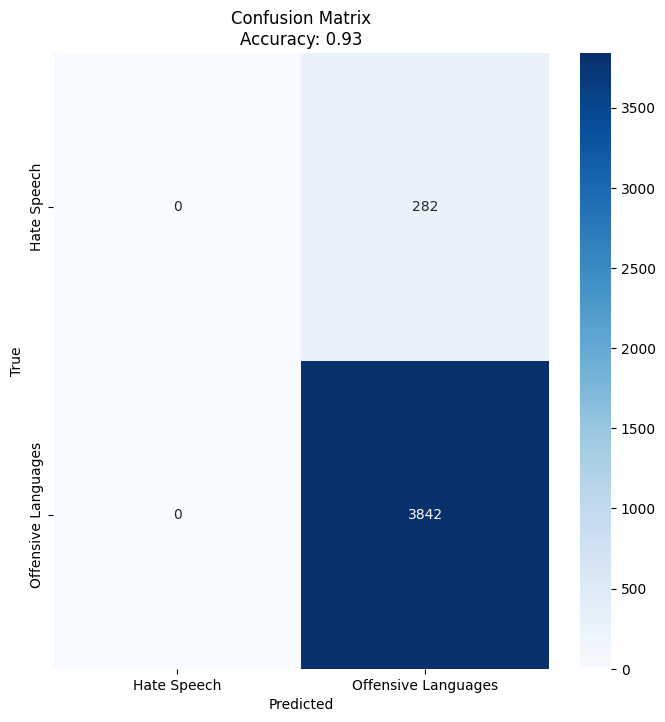

In [40]:
label_dict = {'Hate Speech': 1, 'Offensive Languages': 0}

# Evaluation loop
model.eval()
all_preds = []

with torch.no_grad():
    for batch in dataloader_test:
        input_ids, attention_masks, labels = [tensor.to(device) for tensor in batch]

        outputs = model(input_ids, attention_mask=attention_masks)
        logits = outputs.logits
        preds = torch.argmax(logits, dim=1).cpu().numpy()
        all_preds.extend(preds)

# Evaluate the model
print("BERTweet:")
print(classification_report(y_test, all_preds, target_names=label_dict.keys()))
print(y_test)
print(all_preds)
# Generate confusion matrix
conf_mat = confusion_matrix(y_test, all_preds)
accuracy_bertweet = accuracy_score(y_test, all_preds)

# Display the confusion matrix as a heatmap
plt.figure(figsize=(8, 8))
# sns.heatmap(conf_mat, annot=True, cmap='Blues', xticklabels=label_dict.keys(), yticklabels=label_dict.keys())
sns.heatmap(conf_mat, annot=True, cmap="Blues", fmt='g', xticklabels=label_dict.keys(), yticklabels=label_dict.keys())
plt.title(f'Confusion Matrix\nAccuracy: {accuracy_bertweet:.2f}')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


In [43]:
import pandas as pd
import torch
from transformers import BertweetTokenizer, Trainer, TrainingArguments
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Load your dataset with columns 'tweet' and 'label'
dataset = pd.read_csv('./dataset/cleaned_dataset.csv')

# Load BERTweet model and tokenizer
model_name = "vinai/bertweet-base"
tokenizer = BertweetTokenizer.from_pretrained(model_name, normalization=True)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)

# Preprocess text and split the dataset
def preprocess_text(text):
    cleaned_text = text.strip()
    return cleaned_text

dataset['cleaned_tweet'] = dataset['tweet'].apply(preprocess_text)

# Split the dataset into training, validation, and testing sets
train_texts, test_texts, train_labels, test_labels = train_test_split(
    dataset['cleaned_tweet'],
    dataset['label'],
    test_size=0.2, 
    random_state=42
)

# Tokenize data
train_encodings = tokenizer(train_texts.tolist(), truncation=True, padding=True)
test_encodings = tokenizer(test_texts.tolist(), truncation=True, padding=True)

class TweetDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = TweetDataset(train_encodings, train_labels)
test_dataset = TweetDataset(test_encodings, test_labels)

# Fine-tune the model
training_args = TrainingArguments(
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    logging_dir='./logs',
    logging_steps=100,
    save_steps=100,
    evaluation_strategy="epoch"
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset
)

trainer.train()

# Evaluate the model
predictions = trainer.predict(test_dataset)
predicted_labels = predictions.predictions.argmax(-1)
accuracy = accuracy_score(test_labels, predicted_labels)
print("Accuracy:", accuracy)


emoji is not installed, thus not converting emoticons or emojis into text. Install emoji: pip3 install emoji==0.6.0
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/bertweet-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


TypeError: TrainingArguments.__init__() missing 1 required positional argument: 'output_dir'